# Notebook 4
==============
Modelling

# Importing Packages and Data

In [1]:
import pyfra
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier 
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, recall_score, make_scorer
from imblearn import under_sampling
from imblearn.under_sampling import RandomUnderSampler
from time import sleep
from sklearn.ensemble import AdaBoostClassifier

In [2]:
df = pd.read_pickle('../data/df.p')
n_rows_complete = len(df)

In [3]:
df = df.drop(columns=['adress','gps_origin','latitude','longitude'])
df.municipality.fillna(55,inplace=True)

In [4]:
df_sample=df.sample(frac=0.007,random_state=23)
data = df_sample.drop(columns='Severity',axis=1).select_dtypes(include=np.number).dropna(axis=1)
target = df_sample.Severity
target.value_counts()

1    712
4    654
3    356
2     35
Name: Severity, dtype: int64

In [5]:
X_train, X_test, y_train, y_test  = train_test_split(data, target, test_size=0.2 ,random_state=23)

In [6]:
std_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

In [7]:
k_features = 60
kbest_selector = SelectKBest(k=k_features)
kbest_selector.fit(X_train_scaled,y_train);
X_train_scaled = kbest_selector.transform(X_train_scaled)
X_test_scaled = kbest_selector.transform(X_test_scaled)
print(f'We use {k_features} of the original {df.shape[1]} features')

We use 60 of the original 381 features


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 22  32  74 150 152 153 154 155 161 176 182 188 192 193 195 210 250 259
 260 261 267 272 273 276 282 284 285 291 292 294 295 297 298 299 301 302
 303 304 310 312 315 316 319 321 323 327 328 329 331 342 349 351 368] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [8]:
# Creating a matrix to store the results
result_metrics = pd.DataFrame(columns=['model', 'f1', 'accuracy', 'recall'])
result_metrics

,model,f1,accuracy,recall


In [9]:
# Creating a function to compute and store the results for the respective model
def store_metrics(model_name, model, y_test, y_pred, result_df):
    result_df.loc[model_name, 'model'] = model
    result_df.loc[model_name, 'f1'] = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    result_df.loc[model_name, 'accuracy'] = accuracy_score(y_true=y_test, y_pred=y_pred)
    result_df.loc[model_name, 'recall'] = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
    return result_df

In [10]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=23)

In [11]:
# Instantiation of the SVM Classifier
# We set the cache size to 1600 MB (default: 200 MB) to reduce the computing time.
# The other parameters will be set via grid search.
svc = svm.SVC(cache_size=1600)

# Choosing the parameters for the grid search
svc_params = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': [0.1, 0.5, 'scale'],
    'C': [0.1, 0.5, 1, 2]
}

# Setup of the scoring. 
# We have to define the parameter 'average', because we are not dealing with a binary classification.
# Our sample is balanced, hence we can use a simple approach, using 'micro', which uses the global values of 
# true positives, false negatives and false positives.
f1_scoring = make_scorer(score_func=f1_score, average='micro')

# Instantiation of the GridSearchCv
# n_jobs is set to -1 to use all available threads for computation.
svc_grid = GridSearchCV(svc, param_grid=svc_params, scoring=f1_scoring, cv=cv, n_jobs=-1)

In [12]:
# Fitting the grid search to find the best parameter combination
svc_grid.fit(X_train_scaled, y_train)

# Print result of parameter optimization
print('Best parameter combination: ',svc_grid.best_params_)

# Predict target variable for the test set
svc = svc_grid.best_estimator_
y_svc = svc.predict(X_test_scaled)


Best parameter combination:  {'C': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [13]:
# Calculate the metrics for the optimal svm model and store them in the result_metrics DataFrame 
# The model will be stored as well in the DataFrame
result_metrics = store_metrics(model=svc, model_name='Support Vector Machine',
                               y_test=y_test, y_pred=y_svc,
                               result_df=result_metrics)
# Show the interim result                               
result_metrics

,model,f1,accuracy,recall
Support Vector Machine,"SVC(C=2, cache_size=1600)",0.480498,0.494318,0.494318


In [14]:
#LR

In [15]:
#We use and define logistic Regression with n_jobs=-1 to use all cores
LR = LogisticRegression()
#for parameters we use 3 type of solver and 6 for C
LR_params = {
    'solver': ['liblinear', 'lbfgs', 'saga'], 
    'C': [10**(i) for i in range(-5, 5)]
}

f1_scoring = make_scorer(score_func=f1_score, average='micro')

# Instantiation of the GridSearchCv
LR_grid = GridSearchCV(LR, param_grid=LR_params, scoring=f1_scoring, cv=cv, n_jobs=-1)

In [16]:
# Fitting the grid search to find the best parameter combination
LR_grid.fit(X_train_scaled, y_train)

# Print result of parameter optimization
print('Best parameter combination: ',LR_grid.best_params_)

# Predict target variable for the test set
LR = LR_grid.best_estimator_
y_LR = LR.predict(X_test_scaled)
# Calculate the metrics for the optimal LR model and store them in the result_metrics DataFrame 
# The model will be stored as well in the DataFrame
result_metrics = store_metrics(model=LR, model_name='Logistic Regression',
                               y_test=y_test, y_pred=y_LR,
                               result_df=result_metrics)
# Show the interim result                               
result_metrics

Best parameter combination:  {'C': 10, 'solver': 'saga'}


C:\Users\kayla\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,model,f1,accuracy,recall
Support Vector Machine,"SVC(C=2, cache_size=1600)",0.480498,0.494318,0.494318
Logistic Regression,"LogisticRegression(C=10, solver='saga')",0.484554,0.497159,0.497159


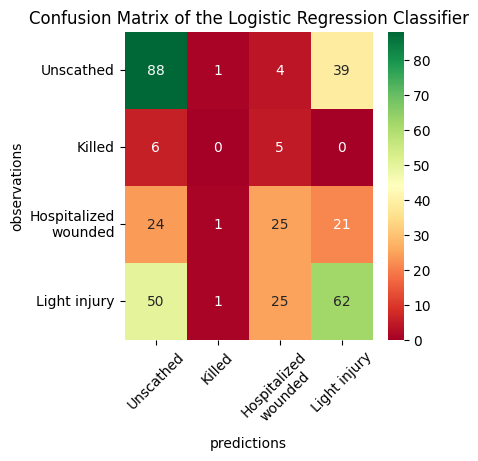

In [17]:
pyfra.print_confusion_matrix(y_test, y_LR, 
                            model_name='Logistic Regression Classifier',
                            filename='Imb_LR')

# Random Forest

In [18]:
params = {
    'criterion': ['gini'],
    'max_depth': [5,10],
    'min_samples_leaf':[3,7],
    'n_estimators': [50,100]
    }

RFCLF = GridSearchCV(RandomForestClassifier(),param_grid = params, cv = cv)
RFCLF.fit(X_train_scaled,y_train)

print('Best Params are:',RFCLF.best_params_)
print('Best Score is:',RFCLF.best_score_)

Best Params are: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}
Best Score is: 0.506405693950178


In [19]:
rf = RFCLF.best_estimator_
y_rf = rf.predict(X_test_scaled)

cm = pd.crosstab(y_test,y_rf, rownames=['Real'], colnames=['Prediction'])
print(cm)

result_metrics = pyfra.store_metrics(model=rf, model_name='Random Forest',
                               y_test=y_test, y_pred=y_rf,
                               result_df=result_metrics)
                              
result_metrics

Prediction    1  3   4
Real                  
1           107  0  25
2             7  2   2
3            45  6  20
4            71  8  59


,model,f1,accuracy,recall
Support Vector Machine,"SVC(C=2, cache_size=1600)",0.480498,0.494318,0.494318
Logistic Regression,"LogisticRegression(C=10, solver='saga')",0.484554,0.497159,0.497159
Random Forest,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.439102,0.488636,0.488636


# Decision Tree

In [20]:
from sklearn import tree
from sklearn.pipeline import Pipeline

# Grid
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
parameters = dict(criterion=criterion, max_depth=max_depth)

DT = GridSearchCV(DecisionTreeClassifier(),param_grid = parameters, cv = RepeatedKFold(n_splits=4, n_repeats=1, random_state=23))
# 
DT.fit(X_train_scaled,y_train)

# 
print('Best Criterion:', DT.best_estimator_.get_params())
print('Best max_depth:', DT.best_estimator_.get_params())
print(); print(DT.best_estimator_.get_params())

Best Criterion: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Best max_depth: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [21]:
dt = DT.best_estimator_
y_dt = dt.predict(X_test_scaled)
cm = pd.crosstab(y_test,y_dt, rownames=['Real'], colnames=['Prediction'])
print(cm)
result_metrics = pyfra.store_metrics(model=dt, model_name='Decision Tree',
                               y_test=y_test, y_pred=y_dt,
                               result_df=result_metrics)
                              
result_metrics

Prediction   1  2   3   4
Real                     
1           88  0   0  44
2            8  0   3   0
3           45  0  11  15
4           69  2  13  54


,model,f1,accuracy,recall
Support Vector Machine,"SVC(C=2, cache_size=1600)",0.480498,0.494318,0.494318
Logistic Regression,"LogisticRegression(C=10, solver='saga')",0.484554,0.497159,0.497159
Random Forest,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.439102,0.488636,0.488636
Decision Tree,"DecisionTreeClassifier(criterion='entropy', ma...",0.406952,0.434659,0.434659


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.


findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


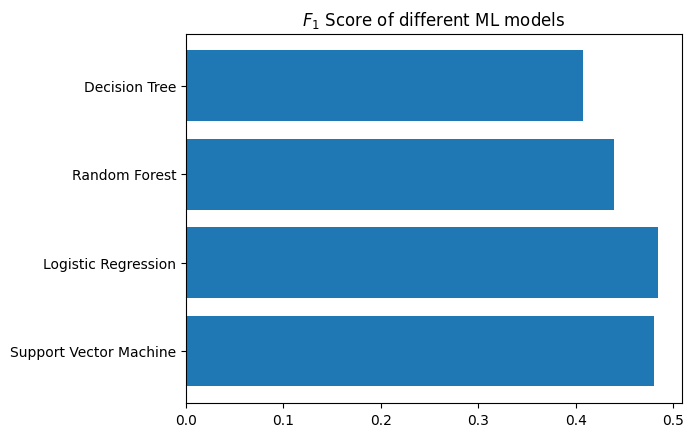

In [22]:
plt.barh(y=result_metrics.index.values, width=result_metrics['f1']);
plt.title('$F_1$ Score of different ML models');

In [23]:
result_metrics.to_pickle('../data/nb_4_results.p')